# Staggered Quantum Walks Simulation on Linear Graphs

> By BoSeong Kim @ Yonsei University (boseong14@gmail.com)

This notebook makes an example of how we could make staggered quantum walks based on the nth root of SWAP operation.  
It requires the same number of qubits, each corresponding to a single node, but it significantly shortens the circuit depth, especially for the cases when the graph is quite comprehensive.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

def staggered_linear_circuit(size: int = 5, t: float = 1., layers: int = 1) -> QuantumCircuit:
    """
    Given size, time t, and the number of layers, constructs the corresponding staggered linear quantum walk circuit.
    Args:
        size: Number of nodes
        t: Total evolving time
        layers: Number of layers
    Returns:
        QuantumCircuit
    """
    
    theta = t*np.pi/layers
    zeta = complex(np.cos(theta), np.sin(theta))
    node_list = np.arange(size)

    nrt_swap = Operator([
        [1, 0, 0, 0],
        [0, 1/2+zeta/2, 1/2-zeta/2, 0],
        [0, 1/2-zeta/2, 1/2+zeta/2, 0],
        [0, 0, 0, 1]
    ])

    simulation = QuantumCircuit(size, size)

    # Start at the center
    simulation.x(int(size/2))

    for i in range(layers):
        
        simulation.barrier()
        
        # Staggered Quantum Walks to right
        for j in node_list[:-1:2]:
            simulation.unitary(nrt_swap, [j, node_list[j+1]], label='nrt_swap')

        # Staggered Quantum Walks to left
        for j in node_list[1::2]:
            simulation.unitary(nrt_swap, [j, node_list[j+1]], label='nrt_swap')
    
    simulation.barrier()
    
    for i in node_list:
        simulation.measure(i, i)
       
    return simulation

In [2]:
size = 5
t = 0.3
layers = 10
shots = 4000

circ = staggered_linear_circuit(size, t, layers)
# circ.draw('mpl')

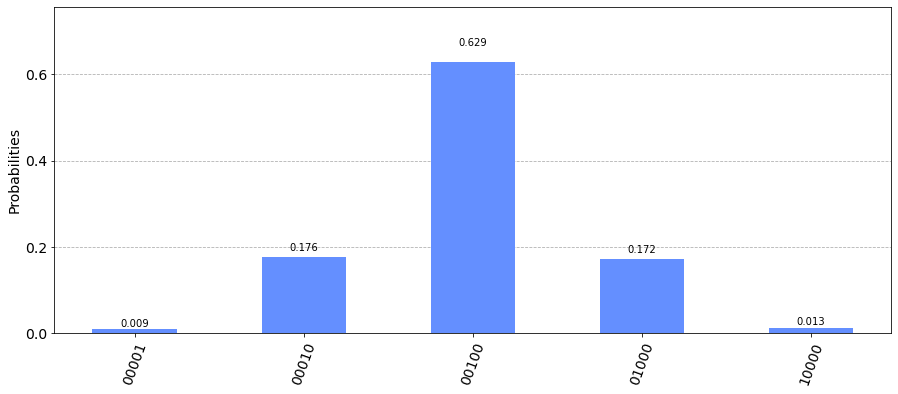

In [3]:
# importing Qiskit
from qiskit import Aer, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circ = transpile(circ, aer_sim, optimization_level=2)
job = aer_sim.run(transpiled_circ, shots=shots)
results = job.result()
counts = results.get_counts()

plot_histogram(counts, figsize=(15,6))